In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
# nltk.download()

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer as Stemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag

df = pd.read_csv('Tweets.csv')
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [2]:
df_sub = df.loc[:, ['tweet_id', 'airline_sentiment', 'text']]
print(df_sub.dtypes)
df_sub.head(5)

tweet_id              int64
airline_sentiment    object
text                 object
dtype: object


,tweet_id,airline_sentiment,text
0,570306133677760513,neutral,@VirginAmerica What @dhepburn said.
1,570301130888122368,positive,@VirginAmerica plus you've added commercials t...
2,570301083672813571,neutral,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,negative,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,negative,@VirginAmerica and it's a really big bad thing...


In [3]:
df_sub['tweet_id'] = df_sub['tweet_id'].astype('str')
print(df_sub.dtypes)
df_sub.head(5)

tweet_id             object
airline_sentiment    object
text                 object
dtype: object


,tweet_id,airline_sentiment,text
0,570306133677760513,neutral,@VirginAmerica What @dhepburn said.
1,570301130888122368,positive,@VirginAmerica plus you've added commercials t...
2,570301083672813571,neutral,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,negative,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,negative,@VirginAmerica and it's a really big bad thing...


In [4]:
test_df = df_sub.loc[df_sub['tweet_id'] == '570083898031513600']
test_df

,tweet_id,airline_sentiment,text
778,570083898031513600,negative,@united I'm constantly having challenges with ...


In [5]:
text = str(test_df['text'].values[0])
text

"@united I'm constantly having challenges with upgrades &amp; charges. In order to prevent DVT I have to pay an addtl $180 http://t.co/xC6jQ70r7B"

In [6]:
def text_processing(text):
    processed_text = text.lower() #lowercaseing
    processed_text = re.sub(r'@[A-Za-z0-9]+', '', processed_text) #remove @user mentions
    processed_text = re.sub(r'https?://[A-Za-z0-9./]+', '', processed_text) #remove URLs
    processed_text = re.sub(r'[^\x00-\x7F]+', '', processed_text) #remove non-ASCII characters
    
    stopWords = set(stopwords.words('english'))
    white_list = ["not", "no", "won't", "isn't", "couldn't", "wasn't", "didn't", "shouldn't", 
    "hasn't", "wouldn't", "haven't", "weren't", "hadn't", "shan't", "doesn't",
    "mightn't", "mustn't", "needn't", "don't", "aren't", "won't"]

    words = processed_text.split()
    processed_text = ' '.join([t for t in words if (t not in stopwords.words('english') or t in white_list)]) #remove stop words

    processed_text = ''.join([t for t in processed_text if t not in string.punctuation]) #remove punctuations
    processed_text = ''.join([t for t in processed_text if not t.isdigit()]) #remove numberic numbers
    
    # def stemmer_text(text):
    #     text = word_tokenize(str(text))   # Init the Wordnet Lemmatizer    
    #     st = Stemmer()  
    #     text = [st.stem(t) for t in text]
    #     return (' '.join(text))
    
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
        
    # use Wordnet(lexical database) to lemmatize text 
    def lemmatize_text(text):
        
        lmtzr = WordNetLemmatizer().lemmatize
        text = word_tokenize(str(text))   # Init the Wordnet Lemmatizer    
        word_pos = pos_tag(text)    
        lemm_words = [lmtzr(sw[0], get_wordnet_pos(sw[1])) for sw in word_pos]
        return (' '.join(lemm_words))

    # processed_text = stemmer_text(processed_text)
    processed_text = lemmatize_text(processed_text)
    return processed_text

print(text_processing(text))

im constantly challenge upgrade amp charge order prevent dvt pay addtl


In [7]:
# df_sub['processed_text'] = df_sub['text'].apply(text_processing)
# df_sub.head(5)

In [8]:
# df_sub.loc[:, ('text')].isnull().sum()

In [9]:
# df_sub.to_csv('yeyintwin_workshop3.csv', index=False)
# print("Done")

In [10]:
df_sub = pd.read_csv('airline_sub.csv')
print(df_sub.shape)
df_sub.head(5)

(14640, 4)


,tweet_id,airline_sentiment,text,processed_text
0,570306133677760513,neutral,@VirginAmerica What @dhepburn said.,say
1,570301130888122368,positive,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky
2,570301083672813571,neutral,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,570301031407624196,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,570300817074462722,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing


In [11]:
nan_count = df_sub['processed_text'].isna().sum()
nan_count

np.int64(11)

In [12]:
df_sub_cleaned = df_sub.dropna()
df_sub_cleaned.shape

(14629, 4)

In [13]:
df_sub_cleaned['label'] = df_sub_cleaned['airline_sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1}) # Negative: -1, neutral: 0, positive 1
df_sub_cleaned.head(5)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_9092\187688392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_cleaned['label'] = df_sub_cleaned['airline_sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1}) # Negative: -1, neutral: 0, positive 1


,tweet_id,airline_sentiment,text,processed_text,label
0,570306133677760513,neutral,@VirginAmerica What @dhepburn said.,say,0
1,570301130888122368,positive,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky,1
2,570301083672813571,neutral,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip,0
3,570301031407624196,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...,-1
4,570300817074462722,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing,-1


In [14]:
# from sklearn.feature_extraction.text import CountVectorizer
 
# document = ["why cancel cancel flight today", 
#             "kudos for not cancel flightling flight from dfw this morning"]
 
# # Create a Vectorizer Object
# vectorizer = CountVectorizer(analyzer = 'word', ngram_range=(1, 1)) 
 
# vectorizer.fit(document)
 
# # Printing the identified Unique words along with their indices
# print("Vocabulary: ", vectorizer.vocabulary_)

In [15]:
# # Encode the Document
# vector = vectorizer.transform(document)
 
# # Summarizing the Encoded Texts
# print("Encoded Document is:")
# print(vector.toarray())

In [16]:
# from sklearn.feature_extraction.text import CountVectorizer

# N = 3
# vector = CountVectorizer(analyzer = 'word', ngram_range = (1, N)) 
# vector_output = vector.fit_transform(df_sub_cleaned['processed_text'])   
# vector_output.shape

In [17]:
# vector_to_array = vector_output.toarray()
# print(vector_to_array)

In [18]:
# from sklearn.feature_extraction.text import TfidfVectorizer
 
# document = ["why cancel cancel flight today", 
#             "kudos for not cancel flightling flight from dfw this morning"]
 
# # Create a Vectorizer Object
# vectorizer = TfidfVectorizer(analyzer = 'word', ngram_range=(1, 1)) 
# vectorizer.fit(document)
 
# # Printing the identified Unique words along with their indices
# print("Vocabulary: ", vectorizer.vocabulary_)

In [19]:
# vector = vectorizer.transform(document)
# print("Encoded Document is:")
# print(vector.toarray())

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

N = 1
vector = TfidfVectorizer(analyzer='word', ngram_range=(1, N))
vector_output = vector.fit_transform(df_sub_cleaned['processed_text'])
vector_output.shape

(14629, 10944)

In [21]:
vector_to_array = vector_output.toarray()
print(vector_to_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


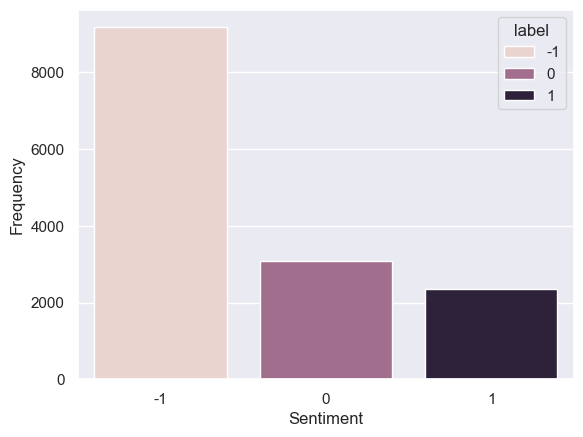

label
-1    9176
 0    3091
 1    2362
Name: count, dtype: int64


In [22]:
sns.set(style="darkgrid")
sns.countplot(x = 'label', data = df_sub_cleaned, order = df_sub_cleaned['label'].value_counts().index, hue = 'label')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

print(df_sub_cleaned['label'].value_counts())

In [23]:
import random
from sklearn.model_selection import train_test_split

random.seed(1234567)

train_X, test_X, train_y, test_y = train_test_split(df_sub_cleaned, df_sub_cleaned['label'], test_size = 0.2, random_state = 101)

In [24]:
train_X.head(5)

,tweet_id,airline_sentiment,text,processed_text,label
2333,569257033972604929,negative,"@united, no, your service here pretty much rui...",no service pretty much ruin day thanks weak at...,-1
9259,570019459244691456,negative,@USAirways i have been patient.. especially th...,patient especially first time never fly,-1
2272,569282692014977025,neutral,@united where's the crew for ua748?,wheres crew ua,0
13499,569847223829307392,neutral,"@AmericanAir Is it true, as FAs are saying, th...",true fa say no way collect money passenger aft...,0
3353,568503174413225984,negative,@united the wifi in the ewr lounge reminds me ...,wifi ewr lounge remind old day dial,-1


In [25]:
train_y.head(5)

2333    -1
9259    -1
2272     0
13499    0
3353    -1
Name: label, dtype: int64

In [26]:
print('Entire dataset', df_sub_cleaned.shape)
print('Train dataset', train_X.shape)
print('Test dataset', test_X.shape)

Entire dataset (14629, 5)
Train dataset (11703, 5)
Test dataset (2926, 5)


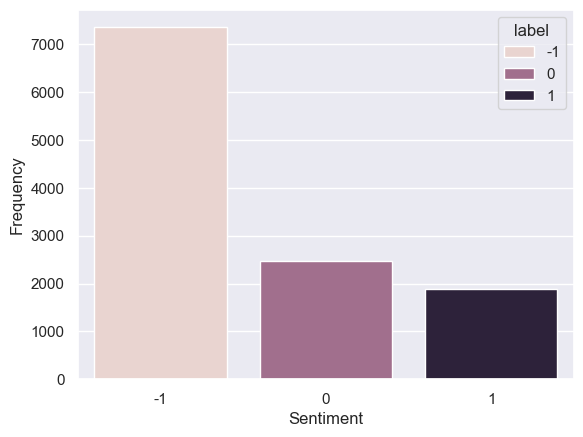

label
-1    7353
 0    2474
 1    1876
Name: count, dtype: int64

In [27]:
sns.set(style="darkgrid")
sns.countplot(x = 'label', data = train_X, order = train_X['label'].value_counts().index, hue="label")
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

train_X['label'].value_counts()

In [28]:
from sklearn.utils import resample
from sklearn.utils import shuffle

# perform oversampling on train dataset
def oversampling(train_X):
    df_major_neg = train_X[train_X['label'] == -1]
    df_minor_neu = train_X[train_X['label'] == 0]
    df_minor_pos = train_X[train_X['label'] == 1]        
    major_count = len(df_major_neg)
 
    # oversample minority class
    df_minor_neu_oversampled = resample(df_minor_neu, 
                                 replace = True,              # sample with replacement
                                 n_samples = major_count,     # to match majority class 
                                 random_state = 1000)    

    df_minor_pos_oversampled = resample(df_minor_pos, 
                                 replace = True,             
                                 n_samples = major_count,   
                                 random_state = 1000)      
         
    trainX = pd.concat([df_major_neg, df_minor_neu_oversampled, df_minor_pos_oversampled])   # Combine majority class with oversampled minority class
    print("Train dataset calss distribution: \n", trainX.label.value_counts())
    trainX = shuffle(trainX, random_state = 200) 
    return trainX

In [29]:
train_X = oversampling(train_X)

Train dataset calss distribution: 
 label
-1    7353
 0    7353
 1    7353
Name: count, dtype: int64


In [30]:
def undersampling(train_X):
    df_major_neg = train_X[train_X['label'] == -1]
    df_minor_neu = train_X[train_X['label'] == 0]
    df_minor_pos = train_X[train_X['label'] == 1]
    
    minor_count = min(len(df_minor_neu), len(df_minor_pos))
 
    df_major_neg_undersampled = resample(df_major_neg, 
                                 replace = False,
                                 n_samples = minor_count,
                                 random_state = 1000)    
    df_minor_neu_undersampled = resample(df_minor_neu,
                                 replace = False,
                                 n_samples = minor_count,
                                 random_state = 1000)

    trainX = pd.concat([df_major_neg_undersampled, df_minor_neu_undersampled, df_minor_pos])
    
    trainX = shuffle(trainX, random_state = 200) 
    
    print("Train dataset class distribution: \n", trainX.label.value_counts())
    
    return trainX

In [31]:
# train_X = undersampling(train_X)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer(analyzer = 'word', ngram_range=(1, 3)) 

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(vector, MultinomialNB(alpha = 1.0, fit_prior = True))
clf = pipe.fit(train_X['processed_text'], train_X['label'])    
test_y_hat = pipe.predict(test_X['processed_text'])


In [34]:
df_result = test_X.copy()
df_result['prediction'] = test_y_hat.tolist()  

df_prob = pd.DataFrame(pipe.predict_proba(test_X['processed_text']), columns = pipe.classes_)
df_prob.index = df_result.index
df_prob.columns = ['probability_negative', 'Probability_neutral', 'probability_positive']

df_final = pd.concat([df_result, df_prob], axis = 1)
    
file_name = 'NB_' + '3' + '_' + 'oversampling' 
df_final.to_csv(file_name + '.csv')  

In [35]:
from sklearn.metrics import f1_score, classification_report,confusion_matrix, accuracy_score

print(pd.crosstab(test_y.to_numpy(), test_y_hat, rownames = ['True'], colnames = ['Predicted'], margins = True)) 

Predicted    -1    0    1   All
True                           
-1         1632  115   76  1823
0           209  308  100   617
1            72   54  360   486
All        1913  477  536  2926


In [36]:
print(classification_report(test_y, test_y_hat))    
print('Macro F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'macro')))  
print('Weighted F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'weighted')))

              precision    recall  f1-score   support

          -1       0.85      0.90      0.87      1823
           0       0.65      0.50      0.56       617
           1       0.67      0.74      0.70       486

    accuracy                           0.79      2926
   macro avg       0.72      0.71      0.71      2926
weighted avg       0.78      0.79      0.78      2926

Macro F1 Score: 0.71
Weighted F1 Score: 0.79


### Naive Bayes model


In [37]:
def airline_NB(df, feature, ngram, sample_method):    
    random.seed(1234567)
        
    if feature == "TF":
        vector = CountVectorizer(analyzer = 'word', ngram_range=(1, ngram)) 
    elif feature == "TFIDF":        
        vector = TfidfVectorizer(analyzer='word', ngram_range=(1, ngram))
        
    train_X, test_X, train_y, test_y = train_test_split(df, df['label'], test_size = 0.2, random_state = 101)
        
    if sample_method == "undersampling":
        train_X = undersampling(train_X)
    
    elif sample_method == "oversampling":    
        train_X = oversampling(train_X)   
              
    pipe = make_pipeline(vector, MultinomialNB(alpha = 1.0, fit_prior = True))
    clf = pipe.fit(train_X['processed_text'], train_X['label'])     
    
    test_y_hat = pipe.predict(test_X['processed_text'])
       
    df_result = test_X.copy()
    df_result['prediction'] = test_y_hat.tolist()   
    
    df_prob = pd.DataFrame(pipe.predict_proba(test_X['processed_text']), columns = pipe.classes_)
    df_prob.index = df_result.index
    df_prob.columns = ['probability_negative', 'Probability_neutral', 'probability_positive']

    df_final = pd.concat([df_result, df_prob], axis = 1)
    
    file_name = 'NB_' + str(ngram) + '_' + sample_method 
    df_final.to_csv(file_name + '.csv')       
    
    print("-----------------------------------------")
    print("NB classification report -- ", "feature: %s/" %feature, "ngram: %d/" %ngram, "sample_method: %s/" %sample_method)
    print(pd.crosstab(test_y.to_numpy(), test_y_hat, rownames = ['True'], colnames = ['Predicted'], margins = True))      

    print("-----------------------------------------")
    print(classification_report(test_y, test_y_hat))    
    print('Macro F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'macro')))  
    print('Weighted F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average = 'weighted')))

### Naive Bayes. Arguments: dataframe, TF/IFIDF, unigran or ngram, data-balancing method   

In [38]:
airline_NB(df_sub_cleaned, "TF", 1, "none")

-----------------------------------------
NB classification report --  feature: TF/ ngram: 1/ sample_method: none/
Predicted    -1    0    1   All
True                           
-1         1725   71   27  1823
0           332  241   44   617
1           160   45  281   486
All        2217  357  352  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.78      0.95      0.85      1823
           0       0.68      0.39      0.49       617
           1       0.80      0.58      0.67       486

    accuracy                           0.77      2926
   macro avg       0.75      0.64      0.67      2926
weighted avg       0.76      0.77      0.75      2926

Macro F1 Score: 0.67
Weighted F1 Score: 0.79


In [39]:
airline_NB(df_sub_cleaned, "TF", 1, "oversampling")

Train dataset calss distribution: 
 label
-1    7353
 0    7353
 1    7353
Name: count, dtype: int64
-----------------------------------------
NB classification report --  feature: TF/ ngram: 1/ sample_method: oversampling/
Predicted    -1    0    1   All
True                           
-1         1507  202  114  1823
0           163  355   99   617
1            54   70  362   486
All        1724  627  575  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.87      0.83      0.85      1823
           0       0.57      0.58      0.57       617
           1       0.63      0.74      0.68       486

    accuracy                           0.76      2926
   macro avg       0.69      0.72      0.70      2926
weighted avg       0.77      0.76      0.76      2926

Macro F1 Score: 0.70
Weighted F1 Score: 0.76


In [40]:
airline_NB(df_sub_cleaned, "TF", 1, "undersampling")

Train dataset class distribution: 
 label
-1    1876
 1    1876
 0    1876
Name: count, dtype: int64
-----------------------------------------
NB classification report --  feature: TF/ ngram: 1/ sample_method: undersampling/
Predicted    -1    0    1   All
True                           
-1         1464  217  142  1823
0           163  344  110   617
1            50   52  384   486
All        1677  613  636  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.87      0.80      0.84      1823
           0       0.56      0.56      0.56       617
           1       0.60      0.79      0.68       486

    accuracy                           0.75      2926
   macro avg       0.68      0.72      0.69      2926
weighted avg       0.76      0.75      0.75      2926

Macro F1 Score: 0.69
Weighted F1 Score: 0.75


In [41]:
airline_NB(df_sub_cleaned, "TFIDF", 2, "none")

-----------------------------------------
NB classification report --  feature: TFIDF/ ngram: 2/ sample_method: none/
Predicted    -1   0   1   All
True                         
-1         1815   8   0  1823
0           548  60   9   617
1           404   9  73   486
All        2767  77  82  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.66      1.00      0.79      1823
           0       0.78      0.10      0.17       617
           1       0.89      0.15      0.26       486

    accuracy                           0.67      2926
   macro avg       0.78      0.41      0.41      2926
weighted avg       0.72      0.67      0.57      2926

Macro F1 Score: 0.41
Weighted F1 Score: 0.76


In [42]:
airline_NB(df_sub_cleaned, "TFIDF", 2, "oversampling")

Train dataset calss distribution: 
 label
-1    7353
 0    7353
 1    7353
Name: count, dtype: int64
-----------------------------------------
NB classification report --  feature: TFIDF/ ngram: 2/ sample_method: oversampling/
Predicted    -1    0    1   All
True                           
-1         1567  156  100  1823
0           185  334   98   617
1            61   58  367   486
All        1813  548  565  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.86      0.86      0.86      1823
           0       0.61      0.54      0.57       617
           1       0.65      0.76      0.70       486

    accuracy                           0.78      2926
   macro avg       0.71      0.72      0.71      2926
weighted avg       0.77      0.78      0.77      2926

Macro F1 Score: 0.71
Weighted F1 Score: 0.78


In [43]:
airline_NB(df_sub_cleaned, "TFIDF", 2, "undersampling")

Train dataset class distribution: 
 label
-1    1876
 1    1876
 0    1876
Name: count, dtype: int64
-----------------------------------------
NB classification report --  feature: TFIDF/ ngram: 2/ sample_method: undersampling/
Predicted    -1    0    1   All
True                           
-1         1534  174  115  1823
0           191  330   96   617
1            68   44  374   486
All        1793  548  585  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.86      0.84      0.85      1823
           0       0.60      0.53      0.57       617
           1       0.64      0.77      0.70       486

    accuracy                           0.76      2926
   macro avg       0.70      0.72      0.70      2926
weighted avg       0.77      0.76      0.76      2926

Macro F1 Score: 0.70
Weighted F1 Score: 0.77


In [44]:
airline_NB(df_sub_cleaned, "TFIDF", 3, "none")

-----------------------------------------
NB classification report --  feature: TFIDF/ ngram: 3/ sample_method: none/
Predicted    -1   0   1   All
True                         
-1         1813  10   0  1823
0           550  59   8   617
1           417   7  62   486
All        2780  76  70  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.65      0.99      0.79      1823
           0       0.78      0.10      0.17       617
           1       0.89      0.13      0.22       486

    accuracy                           0.66      2926
   macro avg       0.77      0.41      0.39      2926
weighted avg       0.72      0.66      0.56      2926

Macro F1 Score: 0.39
Weighted F1 Score: 0.76


In [45]:
airline_NB(df_sub_cleaned, "TFIDF", 3, "oversampling")

Train dataset calss distribution: 
 label
-1    7353
 0    7353
 1    7353
Name: count, dtype: int64
-----------------------------------------
NB classification report --  feature: TFIDF/ ngram: 3/ sample_method: oversampling/
Predicted    -1    0    1   All
True                           
-1         1546  173  104  1823
0           169  346  102   617
1            60   60  366   486
All        1775  579  572  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.87      0.85      0.86      1823
           0       0.60      0.56      0.58       617
           1       0.64      0.75      0.69       486

    accuracy                           0.77      2926
   macro avg       0.70      0.72      0.71      2926
weighted avg       0.77      0.77      0.77      2926

Macro F1 Score: 0.71
Weighted F1 Score: 0.77


In [46]:
airline_NB(df_sub_cleaned, "TFIDF", 3, "undersampling")

Train dataset class distribution: 
 label
-1    1876
 1    1876
 0    1876
Name: count, dtype: int64
-----------------------------------------
NB classification report --  feature: TFIDF/ ngram: 3/ sample_method: undersampling/
Predicted    -1    0    1   All
True                           
-1         1524  183  116  1823
0           187  333   97   617
1            62   46  378   486
All        1773  562  591  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.86      0.84      0.85      1823
           0       0.59      0.54      0.56       617
           1       0.64      0.78      0.70       486

    accuracy                           0.76      2926
   macro avg       0.70      0.72      0.70      2926
weighted avg       0.77      0.76      0.76      2926

Macro F1 Score: 0.70
Weighted F1 Score: 0.76


### SVM Model

In [47]:
from sklearn.svm import SVC

def airline_SVM(df, feature, ngram, sample_method):
    random.seed(1234567)
    
    if feature == "TF":
        vector = CountVectorizer(analyzer='word', ngram_range=(1, ngram)) 
    elif feature == "TFIDF":        
        vector = TfidfVectorizer(analyzer='word', ngram_range=(1, ngram))
        
    train_X, test_X, train_y, test_y = train_test_split(df, df['label'], test_size=0.2, random_state=101)
        
    if sample_method == "undersampling":
        train_X = undersampling(train_X)
    
    elif sample_method == "oversampling":    
        train_X = oversampling(train_X)
              
    # SVM Classifier
    pipe = make_pipeline(vector, SVC(kernel='linear', probability=True, random_state=101))
    clf = pipe.fit(train_X['processed_text'], train_X['label'])
    
    test_y_hat = pipe.predict(test_X['processed_text'])
       
    df_result = test_X.copy()
    df_result['prediction'] = test_y_hat.tolist()   
    
    df_prob = pd.DataFrame(pipe.predict_proba(test_X['processed_text']), columns=pipe.classes_)
    df_prob.index = df_result.index
    df_prob.columns = ['probability_negative', 'Probability_neutral', 'probability_positive']

    df_final = pd.concat([df_result, df_prob], axis=1)
    
    file_name = 'SVM_' + str(ngram) + '_' + sample_method 
    df_final.to_csv(file_name + '.csv')       
    
    print("-----------------------------------------")
    print("SVM classification report -- ", "feature: %s/" %feature, "ngram: %d/" %ngram, "sample_method: %s/" %sample_method)
    print(pd.crosstab(test_y.to_numpy(), test_y_hat, rownames=['True'], colnames=['Predicted'], margins=True))      

    print("-----------------------------------------")
    print(classification_report(test_y, test_y_hat))    
    print('Macro F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average='macro')))  
    print('Weighted F1 Score: {:.2f}'.format(f1_score(test_y_hat, test_y, average='weighted')))         


### SVM. Arguments: dataframe, TF/TFIDF, unigran or ngram, data-balancing method   


In [48]:
airline_SVM(df_sub_cleaned, "TF", 1, "none")

-----------------------------------------
SVM classification report --  feature: TF/ ngram: 1/ sample_method: none/
Predicted    -1    0    1   All
True                           
-1         1558  211   54  1823
0           201  352   64   617
1            82   72  332   486
All        1841  635  450  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.85      0.85      0.85      1823
           0       0.55      0.57      0.56       617
           1       0.74      0.68      0.71       486

    accuracy                           0.77      2926
   macro avg       0.71      0.70      0.71      2926
weighted avg       0.77      0.77      0.77      2926

Macro F1 Score: 0.71
Weighted F1 Score: 0.77


In [49]:
airline_SVM(df_sub_cleaned, "TF", 1, "oversampling")

Train dataset calss distribution: 
 label
-1    7353
 0    7353
 1    7353
Name: count, dtype: int64
-----------------------------------------
SVM classification report --  feature: TF/ ngram: 1/ sample_method: oversampling/
Predicted    -1    0    1   All
True                           
-1         1474  275   74  1823
0           162  368   87   617
1            75   87  324   486
All        1711  730  485  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.86      0.81      0.83      1823
           0       0.50      0.60      0.55       617
           1       0.67      0.67      0.67       486

    accuracy                           0.74      2926
   macro avg       0.68      0.69      0.68      2926
weighted avg       0.75      0.74      0.75      2926

Macro F1 Score: 0.68
Weighted F1 Score: 0.73


In [50]:
airline_SVM(df_sub_cleaned, "TF", 1, "undersampling")

Train dataset class distribution: 
 label
-1    1876
 1    1876
 0    1876
Name: count, dtype: int64
-----------------------------------------
SVM classification report --  feature: TF/ ngram: 1/ sample_method: undersampling/
Predicted    -1    0    1   All
True                           
-1         1239  443  141  1823
0           114  407   96   617
1            47   93  346   486
All        1400  943  583  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.89      0.68      0.77      1823
           0       0.43      0.66      0.52       617
           1       0.59      0.71      0.65       486

    accuracy                           0.68      2926
   macro avg       0.64      0.68      0.65      2926
weighted avg       0.74      0.68      0.70      2926

Macro F1 Score: 0.65
Weighted F1 Score: 0.67


In [51]:
airline_SVM(df_sub_cleaned, "TFIDF", 2, "none")

-----------------------------------------
SVM classification report --  feature: TFIDF/ ngram: 2/ sample_method: none/
Predicted    -1    0    1   All
True                           
-1         1699   84   40  1823
0           280  282   55   617
1           106   40  340   486
All        2085  406  435  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.81      0.93      0.87      1823
           0       0.69      0.46      0.55       617
           1       0.78      0.70      0.74       486

    accuracy                           0.79      2926
   macro avg       0.76      0.70      0.72      2926
weighted avg       0.78      0.79      0.78      2926

Macro F1 Score: 0.72
Weighted F1 Score: 0.81


In [52]:
airline_SVM(df_sub_cleaned, "TFIDF", 2, "oversampling")

Train dataset calss distribution: 
 label
-1    7353
 0    7353
 1    7353
Name: count, dtype: int64
-----------------------------------------
SVM classification report --  feature: TFIDF/ ngram: 2/ sample_method: oversampling/
Predicted    -1    0    1   All
True                           
-1         1659  117   47  1823
0           232  315   70   617
1            82   51  353   486
All        1973  483  470  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.84      0.91      0.87      1823
           0       0.65      0.51      0.57       617
           1       0.75      0.73      0.74       486

    accuracy                           0.80      2926
   macro avg       0.75      0.72      0.73      2926
weighted avg       0.79      0.80      0.79      2926

Macro F1 Score: 0.73
Weighted F1 Score: 0.80


In [53]:
airline_SVM(df_sub_cleaned, "TFIDF", 2, "undersampling")

Train dataset class distribution: 
 label
-1    1876
 1    1876
 0    1876
Name: count, dtype: int64
-----------------------------------------
SVM classification report --  feature: TFIDF/ ngram: 2/ sample_method: undersampling/
Predicted    -1    0    1   All
True                           
-1         1430  273  120  1823
0           133  394   90   617
1            48   58  380   486
All        1611  725  590  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.89      0.78      0.83      1823
           0       0.54      0.64      0.59       617
           1       0.64      0.78      0.71       486

    accuracy                           0.75      2926
   macro avg       0.69      0.73      0.71      2926
weighted avg       0.77      0.75      0.76      2926

Macro F1 Score: 0.71
Weighted F1 Score: 0.75


In [54]:
airline_SVM(df_sub_cleaned, "TFIDF", 3, "none")

-----------------------------------------
SVM classification report --  feature: TFIDF/ ngram: 3/ sample_method: none/
Predicted    -1    0    1   All
True                           
-1         1702   75   46  1823
0           291  269   57   617
1           103   37  346   486
All        2096  381  449  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.81      0.93      0.87      1823
           0       0.71      0.44      0.54       617
           1       0.77      0.71      0.74       486

    accuracy                           0.79      2926
   macro avg       0.76      0.69      0.72      2926
weighted avg       0.78      0.79      0.78      2926

Macro F1 Score: 0.72
Weighted F1 Score: 0.81


In [55]:
airline_SVM(df_sub_cleaned, "TFIDF", 3, "oversampling")

Train dataset calss distribution: 
 label
-1    7353
 0    7353
 1    7353
Name: count, dtype: int64
-----------------------------------------
SVM classification report --  feature: TFIDF/ ngram: 3/ sample_method: oversampling/
Predicted    -1    0    1   All
True                           
-1         1675   98   50  1823
0           255  292   70   617
1            87   46  353   486
All        2017  436  473  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.83      0.92      0.87      1823
           0       0.67      0.47      0.55       617
           1       0.75      0.73      0.74       486

    accuracy                           0.79      2926
   macro avg       0.75      0.71      0.72      2926
weighted avg       0.78      0.79      0.78      2926

Macro F1 Score: 0.72
Weighted F1 Score: 0.80


In [56]:
airline_SVM(df_sub_cleaned, "TFIDF", 3, "undersampling")

Train dataset class distribution: 
 label
-1    1876
 1    1876
 0    1876
Name: count, dtype: int64
-----------------------------------------
SVM classification report --  feature: TFIDF/ ngram: 3/ sample_method: undersampling/
Predicted    -1    0    1   All
True                           
-1         1466  243  114  1823
0           155  369   93   617
1            52   51  383   486
All        1673  663  590  2926
-----------------------------------------
              precision    recall  f1-score   support

          -1       0.88      0.80      0.84      1823
           0       0.56      0.60      0.58       617
           1       0.65      0.79      0.71       486

    accuracy                           0.76      2926
   macro avg       0.69      0.73      0.71      2926
weighted avg       0.77      0.76      0.76      2926

Macro F1 Score: 0.71
Weighted F1 Score: 0.75
